# **Steel Defect Detection**
In this project, I trained deep learning models for detecting steel surface defects using **VGG-like Model** and **Lightweight EfficientNet U-Net** models.

## Summary of Results
Both the VGG-like model and the EfficientNet U-Net achieve similar Dice scores (0.90), indicating strong segmentation quality. However, the VGG-like model delivers slightly better IoU (0.62) and recall (0.73), and trains much faster.

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import random
import pickle
import datetime
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [24]:
print("TF GPU Available:", tf.config.list_physical_devices('GPU'))

TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read and Explore Data
The data used for this project was downloaded from https://www.kaggle.com/competitions/severstal-steel-defect-detection/data

In [25]:
# Load CSV
df = pd.read_csv('/content/drive/MyDrive/severstal-steel-defect-detection/train.csv')
print (df.shape)
print (df.columns)

(7095, 3)
Index(['ImageId', 'ClassId', 'EncodedPixels'], dtype='object')


In [26]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [28]:
df.isna().sum()

,0
ImageId,0
ClassId,0
EncodedPixels,0


In [43]:
# Check unique image numbers and classes
image_ids = df['ImageId'].unique()
print(len(image_ids))
print(df['ClassId'].nunique())
print(df['ClassId'].value_counts(normalize=True,ascending=True))

6666
4
ClassId
2    0.034813
4    0.112896
1    0.126427
3    0.725863
Name: proportion, dtype: float64


In [44]:
print(df['ClassId'].value_counts(ascending=True))

ClassId
2     247
4     801
1     897
3    5150
Name: count, dtype: int64


* There are a total of 6666 unique iamges in the training dataset
* The defect classes are imbalanced, with class 2 comprising only 3.4% of the data, while class 3 accounts for 72.5%.
* Augment the training data for the minority classes.

## Prepare Data for Model Training

In [30]:
# RLE decoding function
def rle_decode(mask_rle, shape=(256, 1600)):
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [31]:
# Data augmentation function
def augment_image_and_mask(img, mask):
    # Random horizontal flip
    if random.random() > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    # Random vertical flip
    if random.random() > 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)
    # Random brightness adjustment
    if random.random() > 0.5:
        factor = 0.7 + 0.6 * random.random()  # Range: 0.7 to 1.3
        img = np.clip(img * factor, 0, 1)
    return img, mask

In [32]:
# Custom Data Generator for efficient and safe multi-threaded data loading
# Useful when working with large datasets that cannot fit entirely into memory.

class SteelDataset(Sequence):
    def __init__(self, df, img_dir, batch_size=16, img_shape=(128, 800), n_classes=4, shuffle=True, augmentation_factors=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.image_ids = self.df['ImageId'].unique()
        self.augmentation_factors = augmentation_factors if augmentation_factors is not None else {1: 1, 2: 1, 3: 1, 4: 1}
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []

        for img_id in batch_ids:
            img_path = os.path.join(self.img_dir, img_id)

            # --- Debug: Check if file exists ---
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")

            img = cv2.imread(img_path)

            # --- Debug: Handle unreadable images ---
            if img is None:
                raise ValueError(f"cv2.imread failed for {img_path}")

            img = cv2.resize(img, self.img_shape[::-1])
            img = img.astype(np.float32) / 255.0

            mask = np.zeros((*self.img_shape, self.n_classes), dtype=np.uint8)

            for c in range(1, self.n_classes+1):
                rle = self.df[(self.df['ImageId'] == img_id) & (self.df['ClassId'] == c)]['EncodedPixels']
                if len(rle) > 0 and isinstance(rle.values[0], str):
                    mask[..., c-1] = rle_decode(rle.values[0], self.img_shape)

            # ---augmentation ---
            for c in [1, 2, 4]:
                if mask[..., c-1].sum() > 0:
                    for _ in range(self.augmentation_factors.get(c, 1) - 1):
                        aug_img, aug_mask = augment_image_and_mask(img, mask)
                        X.append(aug_img)
                        y.append(aug_mask)

            X.append(img)
            y.append(mask)

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)


# Model Construction

## VGG-like Model

In [33]:
# VGG-like Model (Shallow)
def build_vgg_like(input_shape=(128, 800, 3), n_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    outputs = layers.Conv2D(n_classes, 1, activation='sigmoid', padding='same')(x)
    model= models.Model(inputs, outputs)
    return model

## Lightweight EfficientNet U-Net




In [34]:
def build_lightweight_efficientnet_unet(input_shape=(128, 800, 3), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Use EfficientNet as encoder
    backbone = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )

    # Freeze backbone initially
    backbone.trainable = False

    # Get skip connections from EfficientNet
    # These need to be carefully selected to match the decoder upsampling stages
    skip1 = backbone.get_layer('block2a_expand_conv').output # Shape 64x400x96
    skip2 = backbone.get_layer('block3a_expand_conv').output # Shape 32x200x144
    skip3 = backbone.get_layer('block4a_expand_conv').output # Shape 16x100x240
    skip4 = backbone.get_layer('block5a_expand_conv').output # Shape 8x50x672

    # Start from backbone output (bottleneck)
    x = backbone.output  #  4x25x1280

    # Decoder with skip connections
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.UpSampling2D(2)(x)  # 8x50x512
    x = layers.concatenate([x, skip4]) # Concatenate with skip4 (8x50x672) -> 8x50x1184
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.UpSampling2D(2)(x)  # 16x100x512
    x = layers.concatenate([x, skip3]) # Concatenate with skip3 (16x100x240) -> 16x100x752
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.UpSampling2D(2)(x)  # 32x200x256
    x = layers.concatenate([x, skip2]) # Concatenate with skip2 (32x200x144) -> 32x200x400
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.UpSampling2D(2)(x)  # 64x400x128
    x = layers.concatenate([x, skip1]) # Concatenate with skip1 (64x400x96) -> 64x400x224
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)  # 128x800x64
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Output
    outputs = layers.Conv2D(n_classes, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

## Metrics for Model Evaluation

In [46]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def mean_dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculate mean Dice coefficient across all classes"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    dice_scores = []

    # Calculate Dice for each class separately
    for i in range(4):  # 4 classes
        y_true_class = y_true[:, :, :, i]
        y_pred_class = y_pred[:, :, :, i]

        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=[1, 2])
        union = tf.reduce_sum(y_true_class, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2])

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice)

    # Stack and compute mean across classes, then mean across batch
    dice_tensor = tf.stack(dice_scores, axis=1)  # Shape: (batch_size, 4)
    mean_dice_per_sample = tf.reduce_mean(dice_tensor, axis=1)  # Shape: (batch_size,)

    return tf.reduce_mean(mean_dice_per_sample)  # Scalar

def dice_coefficient_per_class(y_true, y_pred, smooth=1e-6):
    """Calculate Dice coefficient for each class individually (for debugging)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate only for class 1 (can be modified for other classes)
    y_true_class = y_true[:, :, :, 0]  # Class 1
    y_pred_class = y_pred[:, :, :, 0]

    intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=[1, 2])
    union = tf.reduce_sum(y_true_class, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)

    return tf.reduce_mean(dice)

def recall_metric(y_true, y_pred, smooth=1e-6):
    """Calculate recall (sensitivity)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    actual_positives = tf.reduce_sum(y_true, axis=[1,2,3])

    recall = (true_positives + smooth) / (actual_positives + smooth)
    return tf.reduce_mean(recall)

def precision_metric(y_true, y_pred, smooth=1e-6):
    """Calculate precision"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    predicted_positives = tf.reduce_sum(y_pred, axis=[1,2,3])

    precision = (true_positives + smooth) / (predicted_positives + smooth)
    return tf.reduce_mean(precision)

def f1_score(y_true, y_pred, smooth=1e-6):
    """Calculate F1 score (harmonic mean of precision and recall)"""
    precision = precision_metric(y_true, y_pred, smooth)
    recall = recall_metric(y_true, y_pred, smooth)

    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1


def per_class_accuracy(y_true, y_pred):
    """Calculate accuracy per class, then average"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    class_accuracies = []
    for i in range(4):
        true_class = y_true[:, :, :, i]
        pred_class = y_pred[:, :, :, i]
        acc = tf.reduce_mean(tf.cast(tf.equal(true_class, pred_class), tf.float32))
        class_accuracies.append(acc)

    return tf.reduce_mean(class_accuracies)


## Loss Function

In [ ]:
# Custom loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Model Training - VGG-like Model

In [47]:
# Split train/val
image_ids = df['ImageId'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.1, random_state=42)
train_df = df[df['ImageId'].isin(train_ids)]
val_df = df[df['ImageId'].isin(val_ids)]
# Get image IDs for each class for training data
class_img_ids = {}
for c in range(1, 5):
    class_img_ids[c] = set(df[df['ClassId'] == c]['ImageId'].unique())
augmentation_factors = {1: 2, 2: 6, 3: 1, 4: 2}
# Generators
train_gen = SteelDataset(train_df, '/content/drive/MyDrive/severstal-steel-defect-detection/train_images', batch_size=4, augmentation_factors=augmentation_factors)
val_gen = SteelDataset(val_df, '/content/drive/MyDrive/severstal-steel-defect-detection/train_images', batch_size=4, shuffle=False)
# Model
model_vgg = build_vgg_like(input_shape=(128, 800, 3))
# model_UNet = build_unet()
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=combined_loss,
                  metrics=[iou_metric, mean_dice_coefficient, recall_metric, f1_score])
# Add callbacks to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_metric',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_metric',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    mode='max'
)

# Train with callbacks
history = model_vgg.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Save model
# model_vgg.save('steel_defect_vgg.h5')
# Save model to Drive
# model_vgg.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_vgg.h5')
model_vgg.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_vgg.keras')

# Save history
with open('/content/drive/MyDrive/severstal-steel-defect-detection/history_vgg.pkl', 'wb') as f:
    pickle.dump(history.history, f)



Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 187s 119ms/step - f1_score: 0.6820 - iou_metric: 0.5633 - loss: 1.0870 - mean_dice_coefficient: 0.8820 - per_class_accuracy: 0.9831 - precision_metric: 0.9860 - recall_metric: 0.5762 - val_f1_score: 0.7354 - val_iou_metric: 0.6163 - val_loss: 1.0352 - val_mean_dice_coefficient: 0.9022 - val_per_class_accuracy: 0.9887 - val_precision_metric: 1.0000 - val_recall_metric: 0.6163 - learning_rate: 5.0000e-04
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 130s 87ms/step - f1_score: 0.6837 - iou_metric: 0.5623 - loss: 1.0533 - mean_dice_coefficient: 0.8865 - per_class_accuracy: 0.9860 - precision_metric: 1.0000 - recall_metric: 0.5623 - val_f1_score: 0.7354 - val_iou_metric: 0.6163 - val_loss: 1.0362 - val_mean_dice_coefficient: 0.9022 - val_per_class_accuracy: 0.9887 - val_precision_metric: 1.0000 - val_recall_metric: 0.6163 - learning_rate: 5.0000e-04
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 129s 86ms/step - f1_score: 0.6956 - iou_metric: 0.5774 - loss: 

In [52]:
model_vgg.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_vgg.keras')

# Save history
with open('/content/drive/MyDrive/severstal-steel-defect-detection/history_vgg.pkl', 'wb') as f:
    pickle.dump(history.history, f)


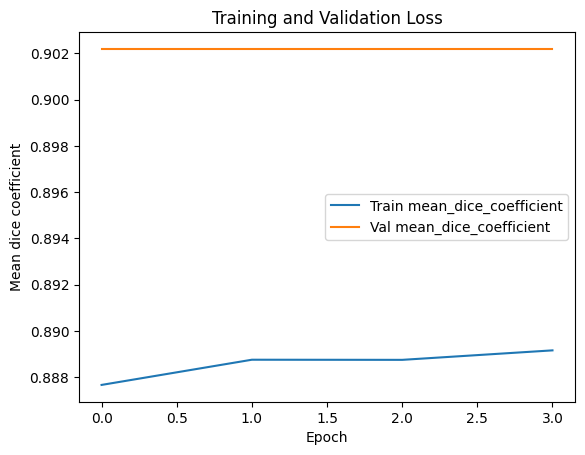

<Figure size 640x480 with 0 Axes>

In [61]:
# Plot training history
plt.plot(history.history['mean_dice_coefficient'], label='Train mean_dice_coefficient')
plt.plot(history.history['val_mean_dice_coefficient'], label='Val mean_dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('Mean dice coefficient')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('/content/drive/MyDrive/severstal-steel-defect-detection/vgg_dice_coefficient_plot.png', dpi=300, bbox_inches='tight')



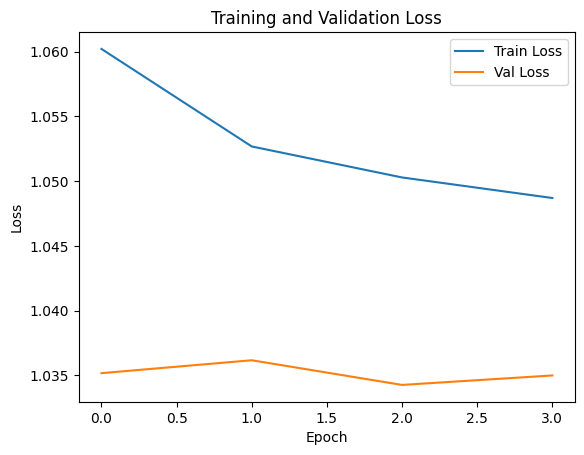

<Figure size 640x480 with 0 Axes>

In [63]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('/content/drive/MyDrive/severstal-steel-defect-detection/vgg_loss_plot.png', dpi=300, bbox_inches='tight')


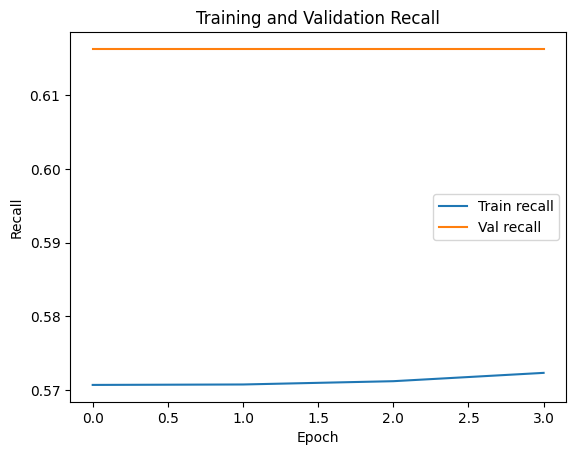

In [59]:
# Plot training history
plt.plot(history.history['recall_metric'], label='Train recall')
plt.plot(history.history['val_recall_metric'], label='Val recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.savefig('/content/drive/MyDrive/severstal-steel-defect-detection/vgg_recall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

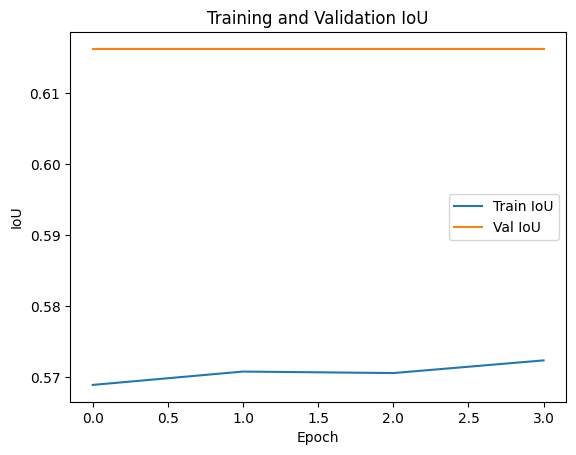

<Figure size 640x480 with 0 Axes>

In [62]:
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Training and Validation IoU')
plt.show()
plt.savefig('/content/drive/MyDrive/severstal-steel-defect-detection/vgg_IoU.png', dpi=300, bbox_inches='tight')

In [51]:

# model = tf.keras.models.load_model('steel_defect_vgg.h5', custom_objects={'iou_metric': iou_metric})

# Evaluate on the whole validation set
results = model_vgg.evaluate(val_gen)
print("Validation loss and metrics:", results)

167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - f1_score: 0.7296 - iou_metric: 0.6086 - loss: 1.0337 - mean_dice_coefficient: 0.9002 - per_class_accuracy: 0.9891 - precision_metric: 1.0000 - recall_metric: 0.6086
Validation loss and metrics: [1.0351696014404297, 0.9886958599090576, 0.6162674427032471, 0.6162674427032471, 1.0, 0.7354426383972168, 0.9021956324577332]


# Model Training - Lightweight EfficientNet U-Net

In [ ]:
# Split train/val
image_ids = df['ImageId'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.1, random_state=42)
train_df = df[df['ImageId'].isin(train_ids)]
val_df = df[df['ImageId'].isin(val_ids)]
# Get image IDs for each class for training data
class_img_ids = {}
for c in range(1, 5):
    class_img_ids[c] = set(df[df['ClassId'] == c]['ImageId'].unique())
augmentation_factors = {1: 2, 2: 6, 3: 1, 4: 2}
# Generators
train_gen = SteelDataset(train_df, '/content/drive/MyDrive/severstal-steel-defect-detection/train_images', batch_size=4, augmentation_factors=augmentation_factors)
val_gen = SteelDataset(val_df, '/content/drive/MyDrive/severstal-steel-defect-detection/train_images', batch_size=4, shuffle=False)
# Model
model_unet = build_lightweight_efficientnet_unet()
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=combined_loss,
                   metrics= metrics=[iou_metric, mean_dice_coefficient, recall_metric, f1_score])

# Add callbacks to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_metric',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_metric',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    mode='max'
)

# Train with callbacks
history = model_unet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Save model
# model_vgg.save('steel_defect_vgg.h5')
# Save model to Drive
# model_vgg.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_vgg.h5')
model_unet.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_unet.keras')

# Save history
import pickle
with open('/content/drive/MyDrive/severstal-steel-defect-detection/history_unet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
# After initial training, unfreeze backbone for fine-tuning
print("Starting fine-tuning phase...")
model_unet.layers[1].trainable = True  # Unfreeze EfficientNet

# Use much lower learning rate for fine-tuning
model_unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  # 10x lower LR
    loss=combined_loss, 
    metrics=[iou_metric, mean_dice_coefficient, recall_metric, f1_score]
)

# Fine-tuning callbacks
finetune_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou_metric',
        patience=3,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_iou_metric',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/severstal-steel-defect-detection/best_model_finetune.keras',
        monitor='val_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Fine-tune the model
history_finetune = model_unet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # Fewer epochs for fine-tuning
    verbose=1,
    callbacks=finetune_callbacks
)

# Save final fine-tuned model
model_unet.save('/content/drive/MyDrive/severstal-steel-defect-detection/steel_defect_unet_finetune.keras')

# Save fine-tuning history
with open('/content/drive/MyDrive/severstal-steel-defect-detection/history_unet_finetune.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

print("Fine-tuning completed!")

# Conclusions

Two segmentation models—a VGG-like CNN and an EfficientNet U-Net—were trained on 6,666 steel plate images with four imbalanced defect classes. On-the-fly augmentation was applied to address imbalance. Both models achieved strong Dice scores (~0.90), but the VGG-like model delivered slightly higher IoU (0.62) and recall (0.73) while training faster.

Despite EfficientNet U-Net’s pretrained encoder and skip connections, the simpler VGG-like model proved more effective. Likely causes include the domain gap between ImageNet pretraining and steel surface textures, and limited data leading to overfitting in the deeper model.

Future work could explore deeper VGG variants with increased data augmentation to balance simplicity with higher representational capacity.